In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity

## Data Processing

In [31]:
# Reading data
ech_forecast_q1 = pd.read_excel('C:/Users/akomarlx/Downloads/PO Tracking_ECH.xlsx', sheet_name = 'ECH Q1')
ech_forecast_q2 = pd.read_excel('C:/Users/akomarlx/Downloads/PO Tracking_ECH.xlsx', sheet_name = 'ECH Q2')
ech_quotes_pegatron = pd.read_excel("C:/Users/akomarlx/Downloads/Solidigm_Pegatron NPI Quote File ww32'22_rev3.xlsx", sheet_name = 'ECHO HARBOR')
ech_quotes_pti = pd.read_excel("C:/Users/akomarlx/Downloads/Solidigm_PTI TW NPI Quote File WW33'22_rev3.xlsm", sheet_name = "EH")

In [56]:
# Lower casing of Site column
ech_forecast_q1['Site'] = ech_forecast_q1['Site'].str.lower()
ech_forecast_q2['Site'] = ech_forecast_q2['Site'].str.lower()
ech_quotes_pegatron['Site'] = 'pegatron'
ech_quotes_pti['Site'] = 'pti'

# Combining forecast data for Q1 and Q2
ech_forecast = pd.concat([ech_forecast_q1, ech_forecast_q2])
ech_forecast.reset_index(drop = True, inplace = True)
ech_forecast.drop(ech_forecast.tail(1).index, inplace=True)

# Combining quote data for PTI and Pegatron
ech_quotes = pd.concat([ech_quotes_pegatron, ech_quotes_pti])
ech_quotes.reset_index(drop = True, inplace = True)

# Merging quote data with forecast data
ech_quotes_po = pd.merge(ech_forecast, ech_quotes, on = 'Build ID', how = 'outer')

In [55]:
# Calculating differences between forecasted cost and quote cost (BOM+MVA)
ech_quotes_po['diff'] = ech_quotes_po[' Cost/unit Forecast'] - ech_quotes_po['BOM+MVA Cost']
# Mean, std, etc. of differences
ech_quotes_po['diff'].describe()

count    108.000000
mean       4.566481
std        0.237157
min        4.330000
25%        4.370000
50%        4.450000
75%        4.770000
max        4.970000
Name: diff, dtype: float64

## Solution

### PTI and Pegatron combined

In [38]:
# Number of builds from both PTI and Pegatron for each difference b/w quote & forecasted cost per unit
ech_groups = ech_quotes_po.groupby(by = ['diff'])
diff_list = []
len_list = []
for key in ech_groups.groups.keys():
    try: 
        diff_list.append(key)
        len_list.append(len(ech_groups.get_group(key)))
    except:
        continue
        
all_list = []
for i in range(0,len(len_list)):
    all_list.extend([diff_list[i]]*len_list[i])

In [36]:
# Range of differences between forecast and quotes
print('Range of differences between forecast and quotes is:', min(diff_list), ' to ', max(diff_list))

Range of differences between forecast and quotes is: 4.33  to  4.970000000000001


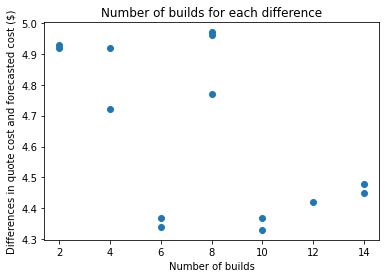

In [10]:
# Visualizing the differences between forecast and quotes
plt.scatter(len_list, diff_list)
plt.ylabel('Differences in quote cost and forecasted cost ($)')
plt.xlabel('Number of builds')
plt.title('Number of builds for each difference')
plt.show()

In [8]:
# Estimate the difference between forecast and quote that is most likely to occur (using Kernel Density Estimation)
inp = np.array(all_list)[~np.isnan(all_list)].reshape(-1, 1)
if len(inp) != 0:
    kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(inp)
    log_dens = kde.score_samples(inp)
    p_dens_list = list(np.exp(log_dens))
    print('The difference b/w true and forecasted quotes that is most likely is', inp[p_dens_list.index(max(p_dens_list))][0])

The difference b/w true and forecasted quotes that is most likely is 4.4799999999999995
